The purpose of this notebook is to:

1. Localize all the necessary data to run DSWx-SAR
2. Create a `yaml` file (proverbially called a RunConfig) for DSWx-SAR
3. Run DSWx-SAR

Most of the code is focused on 1. There are some small todos:

+ Provide an option to serialize data (since re-localizing data takes time and all we need is path)
+ Possibly replace SLC_ID look up in HySDS PST DB with a look up in a table so users don't have to be on PST.

In [1]:
%load_ext autoreload
%autoreload 2

In [54]:
import asf_search as asf
import geopandas as gpd
import pandas as pd
import rasterio
import datetime
from shapely.geometry import shape, Point, box
from rasterio.crs import CRS
from pathlib import Path
from dem_stitcher import stitch_dem
from hand import compute_hand
from tile_stitcher import get_raster_from_tiles
from download_rtc import get_search_client, get_rtc_urls, download_rtc_products, get_burst_df
from dataclasses import dataclass
import yaml
from dswx_sar.dswx_runconfig import RunConfig, WORKFLOW_SCRIPTS_DIR
import requests
from dswx_sar.dswx_s1 import dswx_s1_workflow


In [3]:
WORKFLOW_SCRIPTS_DIR

'/Users/cmarshak/bekaert-team/DSWX-SAR/src/dswx_sar'

# Parameters

In [4]:
## PST S3 Sample

# SLC_ID = 'S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A'
# USE_ASF_DAAC = False

## ASF DAAC

SLC_ID = 'S1A_IW_SLC__1SDV_20240108T232450_20240108T232517_052022_06495E_2EAD'
USE_ASF_DAAC = True

# Out Directory

In [5]:
out_directory = Path('out') / SLC_ID
out_directory.mkdir(exist_ok=True, parents=True)

## Get SLC Metadata

In [6]:
opts = asf.ASFSearchOptions(processingLevel=[asf.PRODUCT_TYPE.SLC],
                            beamMode=[asf.BEAMMODE.IW],
                            platform=[asf.PLATFORM.SENTINEL1]
                            )

resp = asf.granule_search([SLC_ID], opts=opts)
geometry = [shape(r.geojson()['geometry']) for r in resp]
properties = [r.properties for r in resp]
df_slc = gpd.GeoDataFrame(properties,
                          geometry=geometry, crs=CRS.from_epsg(4326))
df_slc['range_start'] = pd.to_datetime(df_slc.startTime)
df_slc['range_end'] = df_slc['range_start'] + pd.Timedelta(days=1)
df_slc.head()

,beamModeType,browse,bytes,centerLat,centerLon,faradayRotation,fileID,flightDirection,groupID,granuleType,...,sensor,startTime,stopTime,url,pgeVersion,fileName,frameNumber,geometry,range_start,range_end
0,IW,None,7887315666,42.6384,-82.3951,None,S1A_IW_SLC__1SDV_20240108T232450_20240108T2325...,ASCENDING,S1A_IWDV_0135_0141_052022_150,SENTINEL_1A_FRAME,...,C-SAR,2024-01-08T23:24:50.731Z,2024-01-08T23:25:17.679Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,003.71,S1A_IW_SLC__1SDV_20240108T232450_20240108T2325...,135,"POLYGON ((-84.15382 43.23674, -83.72439 41.619...",2024-01-08 23:24:50.731000+00:00,2024-01-09 23:24:50.731000+00:00


In [7]:
if (USE_ASF_DAAC) and (df_slc['range_start'][0] < pd.Timestamp('2023-10-01T00:00:00', tz='UTC')):
    raise ValueError('OPERA only started generating RTC products in October 2023')

<Axes: >

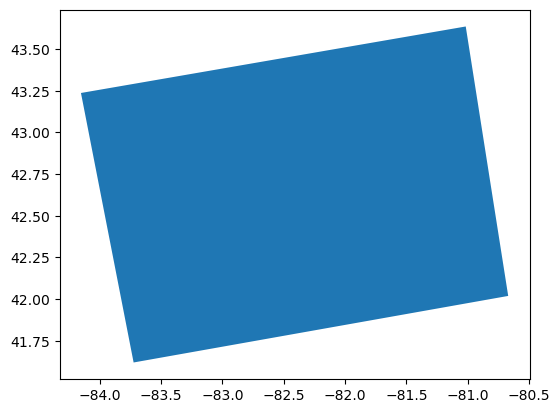

In [8]:
df_slc.plot()

# Auxiliary Datasets

## DEM

In [59]:
bounds = list(df_slc.total_bounds)
print(bounds)
bounds_buffered = list(box(*bounds).buffer(1).bounds)
bounds_buffered

[-84.153824, 41.619595, -80.669395, 43.635811]


[-85.153824, 40.619595, -79.669395, 44.635811]

In [11]:
dst_area_or_point = 'Point'
dem, p_dem = stitch_dem(bounds_buffered, 
                  'glo_30', 
                  dst_area_or_point=dst_area_or_point, 
                  dst_ellipsoidal_height=False)

Reading glo_30 Datasets: 100%|███████████████████████████████████████████| 35/35 [00:41<00:00,  1.20s/it]


In [12]:
dem_path = out_directory / 'glo30_dem.tif'

In [13]:
with rasterio.open(dem_path, 'w', **p_dem) as ds:
   ds.write(dem, 1)
   ds.update_tags(AREA_OR_POINT='Point')

## HAND

In [14]:
%%time

hand = compute_hand(dem_path)

CPU times: user 3min 11s, sys: 16.7 s, total: 3min 27s
Wall time: 3min 2s


In [15]:
hand_path = out_directory / f'hand.tif'

In [16]:
with rasterio.open(hand_path, 'w', **p_dem) as ds:
    ds.write(hand, 1)

## Pekel

In [17]:
X_occ, p_occ = get_raster_from_tiles(bounds_buffered, tile_shortname='peckel_water_occ_2021')

In [18]:
occ_path = out_directory / 'pekel_occ.tif'

In [19]:
with rasterio.open(occ_path, 'w', **p_occ) as ds:
    ds.write(X_occ)

## World Cover

In [20]:
X_esa_wc, p_wc = get_raster_from_tiles(bounds_buffered, tile_shortname='esa_world_cover_2021')

In [21]:
wc_path = out_directory / f'wc.tif'

In [22]:
with rasterio.open(wc_path, 'w', **p_wc) as ds:
    ds.write(X_esa_wc)

In [23]:
X_esa_wc.shape

(1, 48195, 65814)

# Delete Above Rasters in Memory

In [24]:
del X_esa_wc
del dem
del hand
del X_occ

# Download RTC Data

Requires access to ES database and the `.env` file with JPL credentials.

In [25]:
rtc_product_directory = out_directory / 'rtc_products'
rtc_product_directory.mkdir(exist_ok=True, parents=True)

In [26]:
df_burst = get_burst_df()
df_burst.head()

,geometry,burst_id_jpl,is_land,is_north_america,orbit_pass,track
0,"POLYGON ((2.53190 4.75701, 3.29631 4.91201, 3....",t001_000025_iw1,1,False,ASCENDING,1
1,"POLYGON ((3.25912 4.97460, 4.06055 5.13657, 4....",t001_000025_iw2,1,False,ASCENDING,1
2,"POLYGON ((4.02659 5.18854, 4.73485 5.32978, 4....",t001_000025_iw3,1,False,ASCENDING,1
3,"POLYGON ((2.49611 4.92361, 3.26087 5.07851, 3....",t001_000026_iw1,1,False,ASCENDING,1
4,"POLYGON ((3.22392 5.14115, 4.02565 5.30297, 3....",t001_000026_iw2,1,False,ASCENDING,1


In [27]:
url_dict = get_rtc_urls(SLC_ID, 
                        df_slc, 
                        from_asf_daac=USE_ASF_DAAC)

In [28]:
len(url_dict.keys())

32

In [29]:
out_paths = download_rtc_products(url_dict, rtc_product_directory)

100%|██████████████████████████████████████████████████████████████████| 160/160 [01:24<00:00,  1.90it/s]


# Generate Yaml/Runconfig

There are three general steps:

1. Get the defaults/templates for parameters and runconfig.
2. Populate the yml with our data (specifically paths and directories)
3. Load the yml as a Runconfig object for the workflow.

The way we figured this out was to keep going through the 3 steps and try running the RunConfig initialization `RunConfig.load_from_yaml`. Usually the loading tells the user what needs filling out on account of yaml validation. It's not pretty.

In [30]:
# dswx_sar_pge_url = 'https://raw.githubusercontent.com/opera-adt/DSWX-SAR/main/src/dswx_sar/defaults/dswx_s1.yaml'
# dswx_sar_param_url = 'https://raw.githubusercontent.com/opera-adt/DSWX-SAR/main/src/dswx_sar/defaults/algorithm_parameter_s1.yaml'

# resp = requests.get(dswx_sar_pge_url)
# resp_param = requests.get(dswx_sar_param_url)

## Load default ymls from upstream repository

In [31]:
param_path = (Path(WORKFLOW_SCRIPTS_DIR) / 'defaults' / 'algorithm_parameter_s1.yaml')
with open(param_path) as f:
    param_dict = yaml.safe_load(f)
param_dict

{'runconfig': {'name': 'dswx_s1_workflow_algorithm',
  'processing': {'dswx_workflow': 'opera_dswx_s1',
   'polarizations': ['dual-pol'],
   'polarimetric_option': None,
   'reference_water': {'max_value': 100,
    'no_data_value': 255,
    'permanent_water_value': 0.9,
    'drought_erosion_pixel': 10,
    'flood_dilation_pixel': 16},
   'hand': {'mask_value': 200},
   'mosaic': {'mosaic_prefix': 'mosaic',
    'mosaic_cog_enable': True,
    'mosaic_mode': 'first'},
   'filter': {'enabled': True, 'window_size': 5, 'line_per_block': 1000},
   'initial_threshold': {'maximum_tile_size': {'x': 400, 'y': 400},
    'minimum_tile_size': {'x': 40, 'y': 40},
    'selection_method': ['combined'],
    'tile_selection_twele': [0.09, 0.8, 0.97],
    'tile_selection_bimodality': 0.7,
    'extending_method': 'gdal_grid',
    'threshold_method': 'ki',
    'multi_threshold': True,
    'adjust_threshold_nonoverlapped_distribution': True,
    'number_cpu': -1,
    'tile_average': True,
    'line_per_block

In [32]:
input_dict = (Path(WORKFLOW_SCRIPTS_DIR) / 'defaults' / 'dswx_s1.yaml')
with open(input_dict) as f:
    input_dict = yaml.safe_load(f)
input_dict

{'runconfig': {'name': 'dswx_s1_workflow_default',
  'groups': {'pge_name_group': {'pge_name': 'DSWX_S1_PGE'},
   'input_file_group': {'input_file_path': None},
   'dynamic_ancillary_file_group': {'dem_file': None,
    'dem_file_description': None,
    'worldcover_file': None,
    'worldcover_file_description': None,
    'reference_water_file': None,
    'reference_water_file_description': None,
    'hand_file': None,
    'hand_file_description': None,
    'shoreline_shapefile': None,
    'shoreline_shapefile_description': None,
    'algorithm_parameters': None},
   'static_ancillary_file_group': {'static_ancillary_inputs_flag': True,
    'mgrs_database_file': None,
    'mgrs_collection_database_file': None},
   'primary_executable': {'product_type': 'DSWX_S1'},
   'product_path_group': {'product_path': None,
    'scratch_path': None,
    'sas_output_path': None,
    'product_version': None,
    'output_imagery_format': 'COG',
    'output_imagery_compression': 'DEFLATE',
    'output_im

## Injecting parameters in relevant yml

In [33]:
rtc_paths = list(rtc_product_directory.glob('*/'))
rtc_paths_str = list(map(str, rtc_paths))
rtc_paths_str = list(map(lambda s: s + '/', rtc_paths_str))
rtc_paths_str[:3]

['out/S1A_IW_SLC__1SDV_20240108T232450_20240108T232517_052022_06495E_2EAD/rtc_products/OPERA_L2_RTC-S1_T150-320294-IW3_20240108T232510Z_20240110T010045Z_S1A_30_v1.0/',
 'out/S1A_IW_SLC__1SDV_20240108T232450_20240108T232517_052022_06495E_2EAD/rtc_products/OPERA_L2_RTC-S1_T150-320294-IW2_20240108T232509Z_20240110T010045Z_S1A_30_v1.0/',
 'out/S1A_IW_SLC__1SDV_20240108T232450_20240108T232517_052022_06495E_2EAD/rtc_products/OPERA_L2_RTC-S1_T150-320289-IW2_20240108T232455Z_20240110T010045Z_S1A_30_v1.0/']

In [34]:
scratch_dir = (out_directory / 'scratch').resolve()
sas_dir = (out_directory / 'sas').resolve()
product_dir = (out_directory / 'product_path').resolve()
[d.mkdir(exist_ok=True, parents=True) for d in [scratch_dir, sas_dir, product_dir]]

[None, None, None]

In [35]:
input_dict

{'runconfig': {'name': 'dswx_s1_workflow_default',
  'groups': {'pge_name_group': {'pge_name': 'DSWX_S1_PGE'},
   'input_file_group': {'input_file_path': None},
   'dynamic_ancillary_file_group': {'dem_file': None,
    'dem_file_description': None,
    'worldcover_file': None,
    'worldcover_file_description': None,
    'reference_water_file': None,
    'reference_water_file_description': None,
    'hand_file': None,
    'hand_file_description': None,
    'shoreline_shapefile': None,
    'shoreline_shapefile_description': None,
    'algorithm_parameters': None},
   'static_ancillary_file_group': {'static_ancillary_inputs_flag': True,
    'mgrs_database_file': None,
    'mgrs_collection_database_file': None},
   'primary_executable': {'product_type': 'DSWX_S1'},
   'product_path_group': {'product_path': None,
    'scratch_path': None,
    'sas_output_path': None,
    'product_version': None,
    'output_imagery_format': 'COG',
    'output_imagery_compression': 'DEFLATE',
    'output_im

In [36]:
input_dict['runconfig']['groups']['input_file_group']['input_file_path'] = rtc_paths_str
input_dict['runconfig']['groups']['dynamic_ancillary_file_group']['dem_file']= str(dem_path.resolve())
input_dict['runconfig']['groups']['dynamic_ancillary_file_group']['worldcover_file']= str(wc_path.resolve())
input_dict['runconfig']['groups']['dynamic_ancillary_file_group']['hand_file']= str(hand_path.resolve())
input_dict['runconfig']['groups']['dynamic_ancillary_file_group']['reference_water_file']= str(occ_path.resolve())
input_dict['runconfig']['groups']['product_path_group']['scratch_path'] = str(scratch_dir)
input_dict['runconfig']['groups']['product_path_group']['sas_output_path'] = str(sas_dir)
input_dict['runconfig']['groups']['product_path_group']['product_path'] = str(product_dir)

input_dict['runconfig']['groups']['primary_executable']['product_type'] = 'dswx_s1'
input_dict['runconfig']['groups']['static_ancillary_file_group']['static_ancillary_inputs_flag'] = False

Make sure empty string rather than `None` is populated in yml.

In [37]:
# See: https://stackoverflow.com/a/41786451
def represent_none(self, _):
    return self.represent_scalar('tag:yaml.org,2002:null', '')

yaml.add_representer(type(None), represent_none)

In [38]:
params_path = out_directory / 'params.yml'
with open(params_path, 'w') as param_file:
    yaml.dump(param_dict, param_file)

In [39]:
input_dict['runconfig']['groups']['dynamic_ancillary_file_group']['algorithm_parameters'] = str(params_path.resolve())

In [40]:
log_path = str(out_directory/f'{SLC_ID}.log')

@dataclass
class Args:
    """placeholder"""
    debug_mode = False
    log_file = log_path

In [41]:
args = Args()
args

Args()

In [42]:
run_config_path = out_directory / 'run_config.yml'
with open(run_config_path, 'w') as run_config_yaml:
    yaml.dump(input_dict, run_config_yaml)

In [43]:
cfg = RunConfig.load_from_yaml(str(run_config_path), 'dswx_s1', args)

command line log file "out/S1A_IW_SLC__1SDV_20240108T232450_20240108T232517_052022_06495E_2EAD/S1A_IW_SLC__1SDV_20240108T232450_20240108T232517_052022_06495E_2EAD.log" has precedence over runconfig log file "None"


# Run Workflow

In [58]:
dswx_s1_workflow(cfg)

Number of bursts to process: 32
    mosaic geogrid:
        start X: 240930.0
        end X: 533910.0
        start Y: 4845060.0
        end Y: 4594650.0
        spacing X: 30.0
        spacing Y: -30.0
        width: 9766
        length: 8347
        projection: PROJCS["WGS 84 / UTM zone 17N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32617"]]
        number of bands: 1
    mosaicking (1/32): OPERA_L2_RTC-S1_T150-320294-IW3_20240108T232510Z_20240110T010045Z_S1A_30_v1.0_VV.tif
  

 -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1A_IW_SLC__1SDV_20240108T232450_20240108T232517_052022_06495E_2EAD/scratch/bimodality_output_binary_VV_VH.tif ... (8347, 9766)
 -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1A_IW_SLC__1SDV_20240108T232450_20240108T232517_052022_06495E_2EAD/scratch/no_data_area_VV_VH.tif ... (8347, 9766)
 -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1A_IW_SLC__1SDV_20240108T232450_20240108T232517_052022_06495E_2EAD/scratch/mosaic_layovershadow_mask.tif ... (8347, 9766)
 -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1A_IW_SLC__1SDV_20240108T232450_20240108T232517_052022_06495E_2EAD/scratch/interpolated_hand.tif ... (8347, 9766)
 -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1A_IW_SLC__1SDV_20240108T232450_20240108T232517_052022_06495E_2EAD/scratch/temp_inundated_vegetation_VV_VH.tif ... (8347, 9766)
 -- Reading /Users/cmarshak/bekaert-team/dswx-sar-work

fail to find the overlapped rtc


.60...70...80...90...100 - done.
0...10...20...30...40...50..

fail to find the overlapped rtc


.60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100

fail to find the overlapped rtc


.60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100

fail to find the overlapped rtc
